In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.signal as signal

from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [ ]:
def dataFrameToXY(dataFrame, windowSize = 36):
  if not isinstance(dataFrame, np.ndarray):
    dataFrame = dataFrame.to_numpy()

  X = []
  y = []
  for i in range(len(dataFrame) - windowSize):
    row = [[a] for a in dataFrame[i:i + windowSize]]
    X.append(row)
    label = dataFrame[i + windowSize]
    y.append(label)

  return np.array(X), np.array(y)

def plotPredictions(data, title = 'Predictions'):
  plt.figure()
  plt.plot(data['Actuals'][50:100], 'b', label = 'Actuals')
  plt.plot(data['Predictions'][50:100], 'r', label = 'Predictions')
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Magnitude')
  plt.legend()
  plt.grid(True)

def dominantFreq(data, freq, scale = 1, psdThreshold = 0.1, initFreq = 0.5):
  index = 0
  isRange = False
  dominantFreqRange = [initFreq]

  while index < len(data):
    if data[index] > psdThreshold and isRange == False:
      isRange == True
      for magnitude in range(0, int(data[index]*scale), 1):
        dominantFreqRange.append(freq[index])
    elif data[index] < psdThreshold and isRange == True:
      dominantFreqRange.append(freq[index-1])
      isRange = False
    index+=1

  return dominantFreqRange

def plotPSD(data, predictions, fs = 100, title = 'Power Spectral Density', label1 = 'Actuals', label2 = 'Predictions'):
  time = np.arange(len(predictions)) / fs
  freqWelch, dataWelch = signal.welch(data, fs, window = 'hamming', scaling = 'spectrum')
  predictFreqWelch, predictDataWelch = signal.welch(predictions, fs, window = 'hamming', scaling = 'spectrum')

  plt.figure()
  plt.plot(freqWelch, dataWelch, 'b', label = label1)
  plt.plot(predictFreqWelch, predictDataWelch, 'r', label = label2)
  plt.title(title)
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('PSD (V^2)')
  plt.legend()
  plt.grid(True)

In [ ]:
csvLow = '/content/drive/MyDrive/VelocitySignals_Low.csv'
csvLowFiltered = '/content/drive/MyDrive/VelocitySignals_Low_Filtered.csv'
csvHigh = '/content/drive/MyDrive/VelocitySignals_High.csv'
csvHighFiltered = '/content/drive/MyDrive/VelocitySignals_High_Filtered.csv'

#Single Variable

Low apmplitude

In [ ]:
# Load data frame
dataFrame = pd.read_csv(csvLowFiltered, index_col = None)
velocitySignal = dataFrame['velocity']
WINDOW_SIZE = 120

# Slice data frame for training
X_Low, y_Low = dataFrameToXY(velocitySignal, WINDOW_SIZE)
X_train_Low, y_train_Low = X_Low[:int(len(X_Low)*(4/6))], y_Low[:int(len(y_Low)*(4/6))]
X_val_Low, y_val_Low = X_Low[int(len(X_Low)*(4/6)):int(len(X_Low))], y_Low[int(len(y_Low)*(4/6)):int(len(y_Low))]

# Configure model parameters
modelLow = Sequential()
modelLow.add(InputLayer((WINDOW_SIZE, 1)))
modelLow.add(GRU(84))
modelLow.add(Dropout(0.2))
modelLow.add(Dense(16, 'relu'))
modelLow.add(Dropout(0.2))
modelLow.add(Dense(8, 'relu'))
modelLow.add(Dropout(0.2))
modelLow.add(Dense(1, 'linear'))

checkPoints = ModelCheckpoint('modelLow/', save_best_only = True)
modelLow.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.0001), metrics = [RootMeanSquaredError()])

modelLow.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 84)                21924     
                                                                 
 dropout (Dropout)           (None, 84)                0         
                                                                 
 dense (Dense)               (None, 16)                1360      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9

In [ ]:
# Train model
modelLow.fit(X_train_Low, y_train_Low, validation_data = (X_val_Low, y_val_Low), epochs = 50, callbacks = [checkPoints])

Epoch 1/50
135/135 [==============================] - 15s 36ms/step - loss: 21.7981 - root_mean_squared_error: 4.6688 - val_loss: 11.1515 - val_root_mean_squared_error: 3.3394
Epoch 2/50
135/135 [==============================] - 5s 37ms/step - loss: 14.8524 - root_mean_squared_error: 3.8539 - val_loss: 7.7261 - val_root_mean_squared_error: 2.7796
Epoch 3/50
135/135 [==============================] - 5s 39ms/step - loss: 12.2670 - root_mean_squared_error: 3.5024 - val_loss: 6.5302 - val_root_mean_squared_error: 2.5554
Epoch 4/50
135/135 [==============================] - 5s 35ms/step - loss: 10.9451 - root_mean_squared_error: 3.3083 - val_loss: 5.5723 - val_root_mean_squared_error: 2.3606
Epoch 5/50
135/135 [==============================] - 5s 38ms/step - loss: 10.2013 - root_mean_squared_error: 3.1939 - val_loss: 4.8096 - val_root_mean_squared_error: 2.1931
Epoch 6/50
135/135 [==============================] - 5s 37ms/step - loss: 9.2307 - root_mean_squared_error: 3.0382 - val_loss: 

68/68 [==============================] - 1s 4ms/step


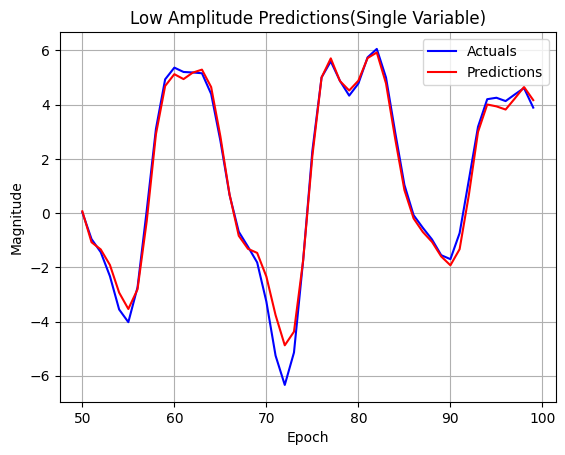

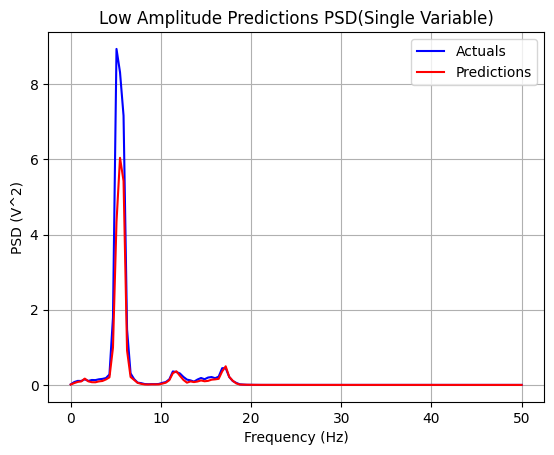

In [ ]:
# Make predictions
modelLow = load_model('modelLow/')
predictions_Low = modelLow.predict(X_val_Low).flatten()
results = pd.DataFrame(data = {'Predictions':predictions_Low, 'Actuals':y_val_Low})

# Plot predictions
plotPredictions(results, title = 'Low Amplitude Predictions(Single Variable)')

# Validate predictions
plotPSD(y_Low, predictions_Low, title = 'Low Amplitude Predictions PSD(Single Variable)')

High Amplitude

In [ ]:
# Load data frame
dataFrame = pd.read_csv(csvHigh, index_col = None)
velocitySignal = dataFrame['velocity']
WINDOW_SIZE = 120

# Slice data frame for training
X_High, y_High = dataFrameToXY(velocitySignal, WINDOW_SIZE)
X_train_High, y_train_High = X_High[:int(len(X_High)*(4/6))], y_High[:int(len(y_High)*(4/6))]
X_val_High, y_val_High = X_High[int(len(X_High)*(4/6)):int(len(X_High))], y_High[int(len(y_High)*(4/6)):int(len(y_High))]

# Configure model parameters
modelHigh = Sequential()
modelHigh.add(InputLayer((WINDOW_SIZE, 1)))
modelHigh.add(GRU(84))
modelHigh.add(Dropout(0.2))
modelHigh.add(Dense(16, 'relu'))
modelHigh.add(Dropout(0.1))
modelHigh.add(Dense(8, 'relu'))
modelHigh.add(Dropout(0.2))
modelHigh.add(Dense(1, 'linear'))

checkPoints = ModelCheckpoint('modelHigh/', save_best_only = True)
modelHigh.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.0001), metrics = [RootMeanSquaredError()])

modelHigh.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 84)                21924     
                                                                 
 dropout (Dropout)           (None, 84)                0         
                                                                 
 dense (Dense)               (None, 16)                1360      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9

In [ ]:
# Train model
modelHigh.fit(X_train_High, y_train_High, validation_data = (X_val_High, y_val_High), epochs = 50, callbacks = [checkPoints])

Epoch 1/50
127/127 [==============================] - 6s 34ms/step - loss: 0.0131 - root_mean_squared_error: 0.1144 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1286
Epoch 2/50
127/127 [==============================] - 9s 74ms/step - loss: 0.0105 - root_mean_squared_error: 0.1024 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1111
Epoch 3/50
127/127 [==============================] - 5s 39ms/step - loss: 0.0084 - root_mean_squared_error: 0.0915 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0945
Epoch 4/50
127/127 [==============================] - 4s 31ms/step - loss: 0.0069 - root_mean_squared_error: 0.0830 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0787
Epoch 5/50
127/127 [==============================] - 5s 39ms/step - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0718
Epoch 6/50
127/127 [==============================] - 5s 41ms/step - loss: 0.0051 - root_mean_squared_error: 0.0711 - val_loss: 0.0047 

64/64 [==============================] - 1s 4ms/step


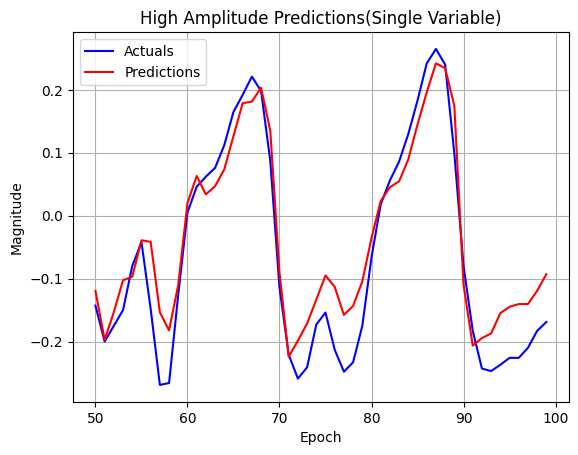

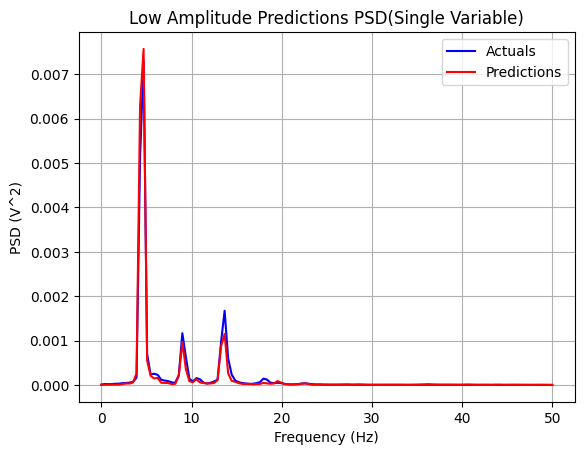

In [ ]:
# Make predictions
modelHigh = load_model('modelHigh/')
predictions_High = modelHigh.predict(X_val_High).flatten()
results = pd.DataFrame(data = {'Predictions':predictions_High, 'Actuals':y_val_High})

# Plot predictions
plotPredictions(results, title = 'High Amplitude Predictions(Single Variable)')

# Validate predictions
plotPSD(y_High, predictions_High, title = 'Low Amplitude Predictions PSD(Single Variable)')

#New data generator

Low Amplitude

In [ ]:
import random

def generateSineSignal(data, frequencies, numSamples = 1000, samplingRate = 240):
  # numSamples = int(desiredTime * samplingRate)
  time = np.arange(0, numSamples, 1/samplingRate)
  # signal = np.zeros(numSamples)
  signal = [0]

  mean = abs(np.mean(data))
  rms = np.sqrt(mean)

  squareDiff = np.square(data - mean)
  squareDiffMean = np.mean(squareDiff)
  std = np.sqrt(squareDiffMean)

  for index in range(0, len(time) - 1, 1):
    frequency = np.random.choice(frequencies)
    magnitude = np.random.uniform(0.8, 1.2) * rms + np.random.uniform(0.0, std)

    sineWave = magnitude * np.sin(2 * np.pi * time[index] * frequency)
    signal.append(sineWave)

  return signal

# Identify the dominant Frequencies
freqWelch, dataWelch = signal.welch(y_Low, fs = 100, window = 'hamming', scaling = 'spectrum')
dominantFrequencies = dominantFreq(dataWelch, freqWelch, scale = 100, psdThreshold = 0.1, initFreq = 4)
random.shuffle(dominantFrequencies)

sineWaveLow = np.array(generateSineSignal(y_Low, dominantFrequencies, numSamples = len(y_Low), samplingRate = 100))

NameError: ignored

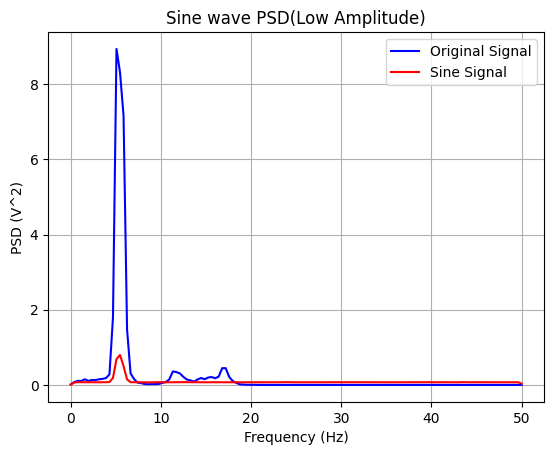

In [ ]:
# Plot sine singal PSD
plotPSD(y_Low ,sineWaveLow, title = 'Sine wave PSD(Low Amplitude)', label1 = 'Original Signal', label2 = 'Sine Signal')

dataFrameSineWaveLow = pd.DataFrame(sineWaveLow, columns = ['velocity'])
dataFrameSineWaveLow = dataFrame['velocity']

191/191 [==============================] - 1s 4ms/step


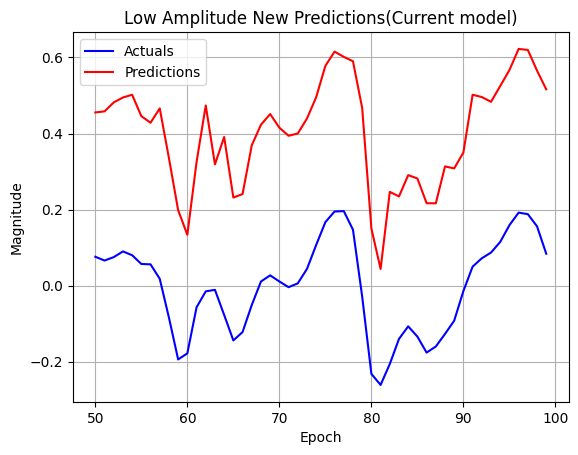

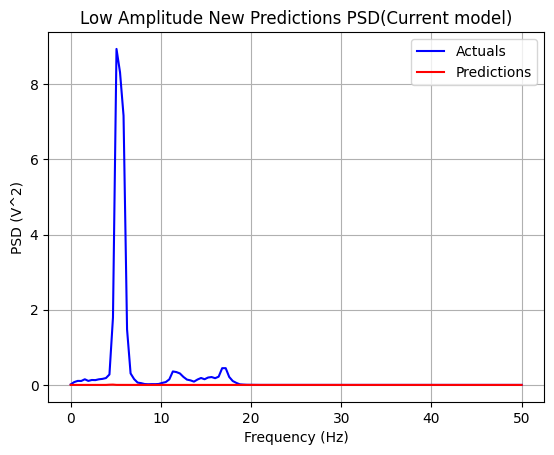

In [ ]:
# Current model New data SV
X_Low_new, y_Low_new = dataFrameToXY(dataFrameSineWaveLow, WINDOW_SIZE)

# Make predictions
modelLow = load_model('modelLow/')
predictions = modelLow.predict(X_Low_new).flatten()
results = pd.DataFrame(data = {'Predictions':predictions, 'Actuals':y_Low_new})

# Plot predictions
plotPredictions(results, title = 'Low Amplitude New Predictions(Current model)')

# Validate predictions
plotPSD(y_Low ,predictions, title = 'Low Amplitude New Predictions PSD(Current model)')

In [ ]:
# New Model New Data
WINDOW_SIZE = 120

X_Low_new, y_Low_new = dataFrameToXY(dataFrameSineWaveLow, WINDOW_SIZE)
X_train_Low_new, y_train_Low_new = X_Low_new[:int(len(X_Low_new)*(4/6))], y_Low_new[:int(len(y_Low_new)*(4/6))]
X_val_Low_new, y_val_Low_new = X_Low_new[int(len(X_Low_new)*(4/6)):int(len(X_Low_new))], y_Low_new[int(len(y_Low_new)*(4/6)):int(len(y_Low_new))]

# Configure model parameters
modelLow_new = Sequential()
modelLow_new.add(InputLayer((WINDOW_SIZE, 1)))
modelLow_new.add(GRU(84))
modelLow_new.add(Dropout(0.2))
modelLow_new.add(Dense(16, 'relu'))
modelLow_new.add(Dropout(0.2))
modelLow_new.add(Dense(8, 'relu'))
modelLow_new.add(Dropout(0.2))
modelLow_new.add(Dense(1, 'linear'))

checkPoints = ModelCheckpoint('modelLow_new/', save_best_only = True)
modelLow_new.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.0001), metrics = [RootMeanSquaredError()])

# Train model
modelLow_new.fit(X_train_Low_new, y_train_Low_new, validation_data = (X_val_Low_new, y_val_Low_new), epochs = 50, callbacks = [checkPoints])

Epoch 1/50
127/127 [==============================] - 8s 45ms/step - loss: 0.0116 - root_mean_squared_error: 0.1079 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1198
Epoch 2/50
127/127 [==============================] - 5s 37ms/step - loss: 0.0093 - root_mean_squared_error: 0.0967 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043
Epoch 3/50
127/127 [==============================] - 4s 31ms/step - loss: 0.0079 - root_mean_squared_error: 0.0890 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0935
Epoch 4/50
127/127 [==============================] - 4s 35ms/step - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0868
Epoch 5/50
127/127 [==============================] - 6s 45ms/step - loss: 0.0063 - root_mean_squared_error: 0.0796 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0818
Epoch 6/50
127/127 [==============================] - 4s 32ms/step - loss: 0.0060 - root_mean_squared_error: 0.0775 - val_loss: 0.0058 

64/64 [==============================] - 1s 4ms/step


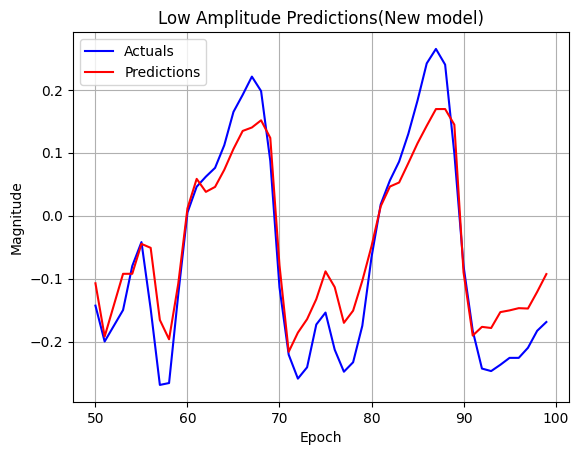

In [ ]:
# Make predictions
modelLow_new = load_model('modelLow_new/')
predictions = modelLow_new.predict(X_val_Low_new).flatten()
results = pd.DataFrame(data = {'Predictions':predictions, 'Actuals':y_val_Low_new})

# Plot predictions
plotPredictions(results, title = 'Low Amplitude Predictions(New model)')

68/68 [==============================] - 2s 30ms/step


Text(0, 0.5, 'Time (s)')

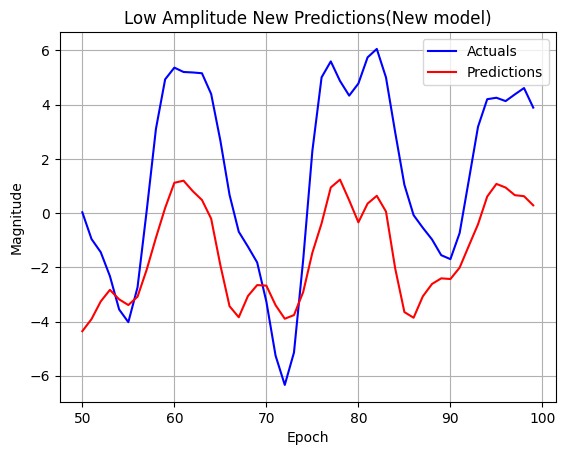

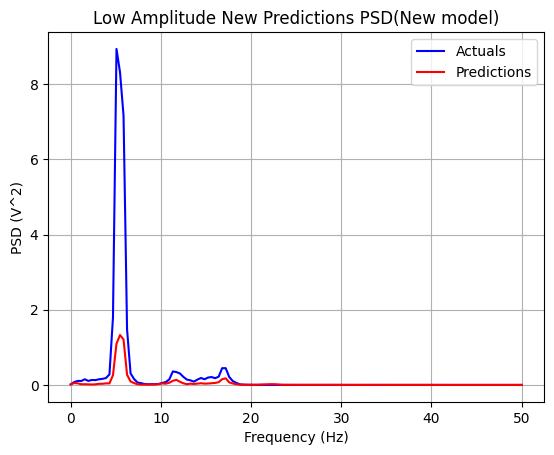

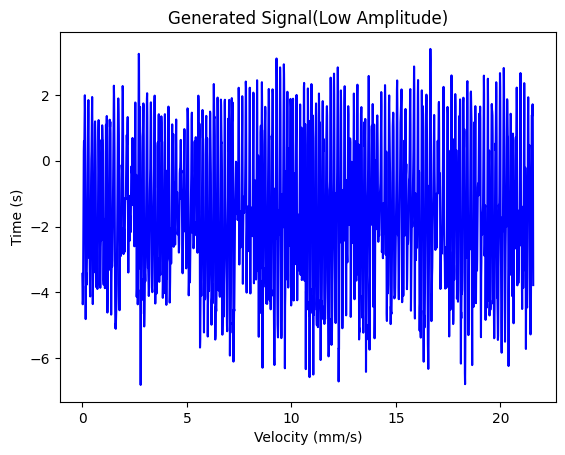

In [ ]:
# Make new predictions
newPredictions = modelLow_new.predict(X_val_Low).flatten()
newResults = pd.DataFrame(data = {'Predictions':newPredictions, 'Actuals':y_val_Low})

# Plot new predictions
plotPredictions(newResults, title = 'Low Amplitude New Predictions(New model)')

# Validate predictions
plotPSD(y_Low ,newPredictions, title = 'Low Amplitude New Predictions PSD(New model)')

samplingRate = 100
time = np.arange(len(newPredictions)) / samplingRate

# Plot Generated Signal
plt.figure()
plt.plot(time, newPredictions, 'b')
plt.title('Generated Signal(Low Amplitude)')
plt.xlabel('Velocity (mm/s)')
plt.ylabel('Time (s)')

High Amplitude

In [ ]:
# Identify the dominant Frequencies
freqWelch, dataWelch = signal.welch(y_High, fs = 100, window = 'hamming', scaling = 'spectrum')
dominantFrequencies = dominantFreq(dataWelch, freqWelch, scale = 100000, psdThreshold = 0.0003, initFreq = 4)
# random.shuffle(dominantFrequencies)

sineWaveHigh = np.array(generateSineSignal(y_High, dominantFrequencies, numSamples = len(y_High), samplingRate = 100))

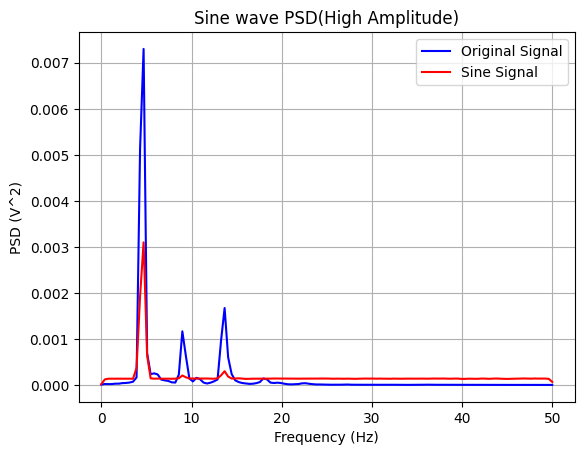

In [ ]:
# Plot sine signal PSD
plotPSD(y_High ,sineWaveHigh, title = 'Sine wave PSD(High Amplitude)', label1 = 'Original Signal', label2 = 'Sine Signal')

dataFrameSineWaveHigh = pd.DataFrame(sineWaveHigh, columns = ['velocity'])
dataFrameSineWaveHigh = dataFrame['velocity']

191/191 [==============================] - 1s 3ms/step


Text(0, 0.5, 'Time (s)')

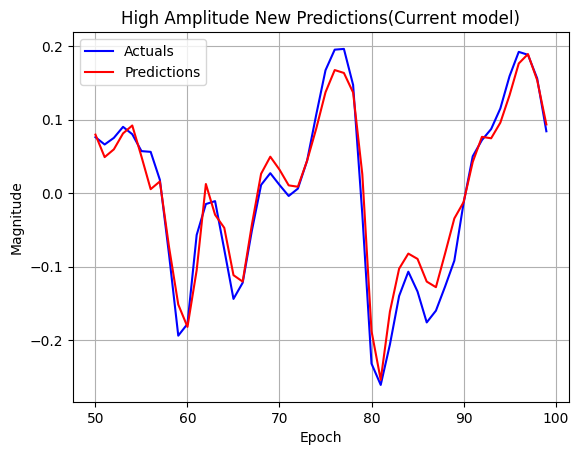

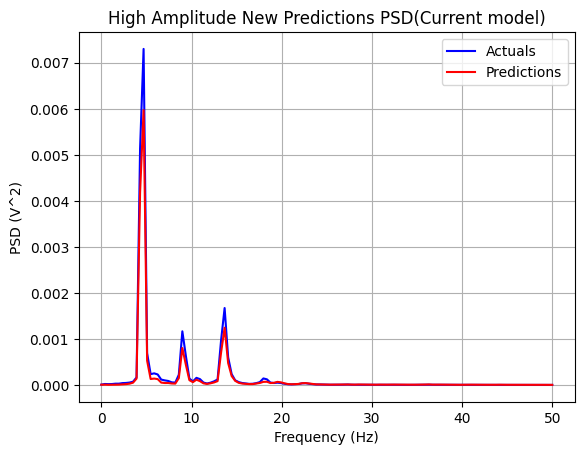

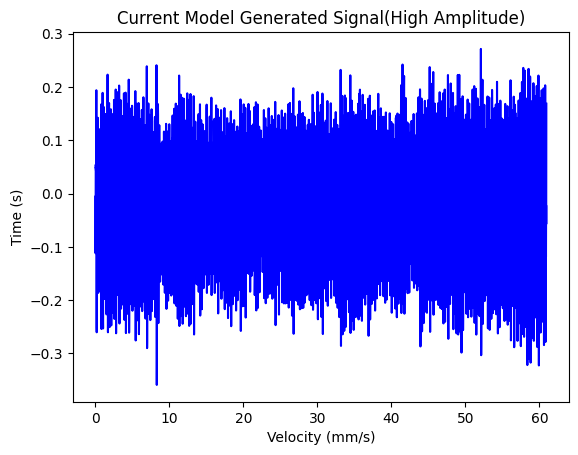

In [ ]:
# Current model New data SV
X_High_new, y_High_new = dataFrameToXY(dataFrameSineWaveHigh, WINDOW_SIZE)

# Make predictions
modelHigh = load_model('modelHigh/')
predictions = modelHigh.predict(X_High_new).flatten()
results = pd.DataFrame(data = {'Predictions':predictions, 'Actuals':y_High_new})

# Plot predictions
plotPredictions(results, title = 'High Amplitude New Predictions(Current model)')

# Validate predictions
plotPSD(y_High ,predictions, title = 'High Amplitude New Predictions PSD(Current model)')

samplingRate = 100
time = np.arange(len(predictions)) / samplingRate

# Plot Generated Signal
plt.figure()
plt.plot(time, predictions, 'b')
plt.title('Current Model Generated Signal(High Amplitude)')
plt.xlabel('Velocity (mm/s)')
plt.ylabel('Time (s)')

In [ ]:
# New Model New Data
WINDOW_SIZE = 120

X_High_new, y_High_new = dataFrameToXY(dataFrameSineWaveHigh, WINDOW_SIZE)
X_train_High_new, y_train_High_new = X_High_new[:int(len(X_High_new)*(4/6))], y_High_new[:int(len(y_High_new)*(4/6))]
X_val_High_new, y_val_High_new = X_High_new[int(len(X_High_new)*(4/6)):int(len(X_High_new))], y_High_new[int(len(y_High_new)*(4/6)):int(len(y_High_new))]

# Configure model parameters
modelHigh_new = Sequential()
modelHigh_new.add(InputLayer((WINDOW_SIZE, 1)))
modelHigh_new.add(GRU(84))
modelHigh_new.add(Dropout(0.2))
modelHigh_new.add(Dense(16, 'relu'))
modelHigh_new.add(Dropout(0.2))
modelHigh_new.add(Dense(8, 'relu'))
modelHigh_new.add(Dropout(0.2))
modelHigh_new.add(Dense(1, 'linear'))

checkPoints = ModelCheckpoint('modelHigh_new/', save_best_only = True)
modelHigh_new.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.0001), metrics = [RootMeanSquaredError()])

# Train model
modelHigh_new.fit(X_train_High_new, y_train_High_new, validation_data = (X_val_High_new, y_val_High_new), epochs = 50, callbacks = [checkPoints])

Epoch 1/50
127/127 [==============================] - 7s 37ms/step - loss: 0.0119 - root_mean_squared_error: 0.1089 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1202
Epoch 2/50
127/127 [==============================] - 5s 41ms/step - loss: 0.0096 - root_mean_squared_error: 0.0981 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1051
Epoch 3/50
127/127 [==============================] - 4s 31ms/step - loss: 0.0083 - root_mean_squared_error: 0.0913 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0935
Epoch 4/50
127/127 [==============================] - 4s 31ms/step - loss: 0.0071 - root_mean_squared_error: 0.0840 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0795
Epoch 5/50
127/127 [==============================] - 5s 40ms/step - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0734
Epoch 6/50
127/127 [==============================] - 5s 36ms/step - loss: 0.0058 - root_mean_squared_error: 0.0763 - val_loss: 0.0050 

64/64 [==============================] - 1s 4ms/step


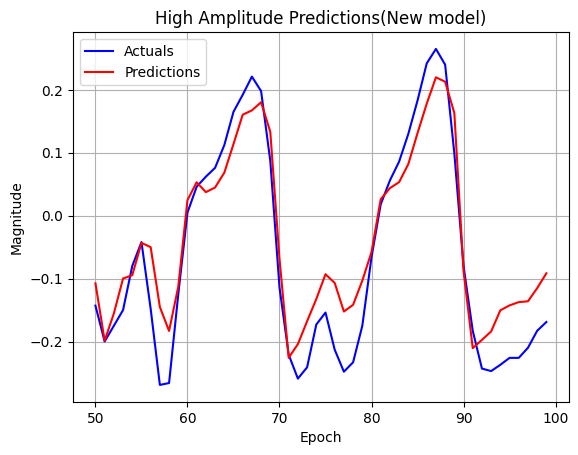

In [ ]:
# Make predictions
modelHigh_new = load_model('modelHigh_new/')
predictions = modelHigh_new.predict(X_val_High_new).flatten()
results = pd.DataFrame(data = {'Predictions':predictions, 'Actuals':y_val_High_new})

# Plot predictions
plotPredictions(results, title = 'High Amplitude Predictions(New model)')

64/64 [==============================] - 0s 5ms/step


Text(0, 0.5, 'Time (s)')

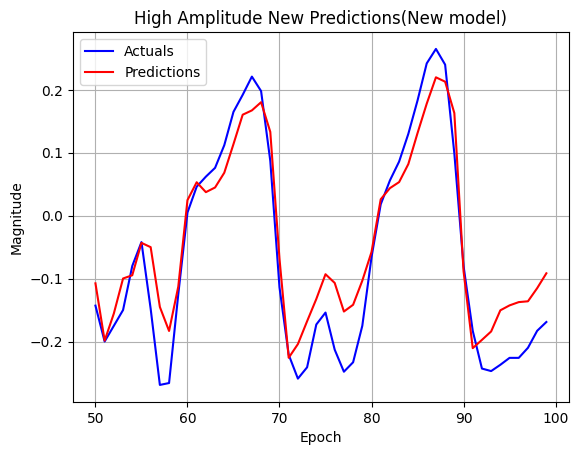

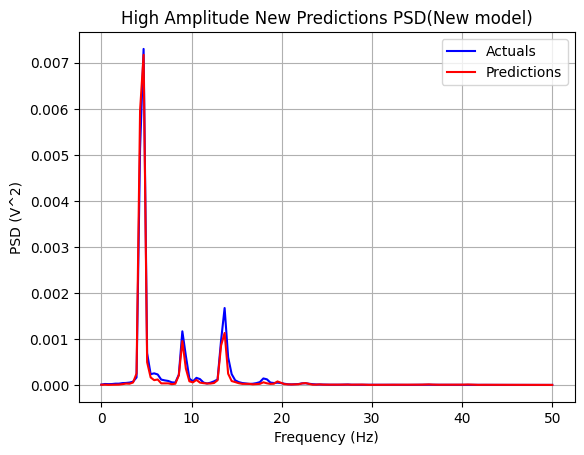

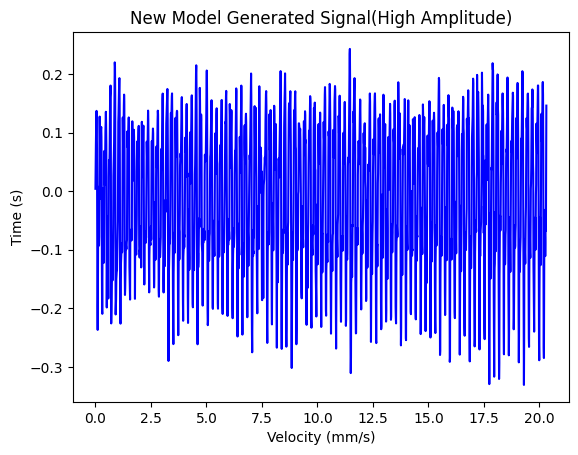

In [ ]:
# Make new predictions
newPredictions = modelHigh_new.predict(X_val_High_new).flatten()
newResults = pd.DataFrame(data = {'Predictions':newPredictions, 'Actuals':y_val_High_new})

# Plot new predictions
plotPredictions(newResults, title = 'High Amplitude New Predictions(New model)')

# Validate predictions
plotPSD(y_High ,newPredictions, title = 'High Amplitude New Predictions PSD(New model)')

samplingRate = 100
time = np.arange(len(newPredictions)) / samplingRate

# Plot Generated Signal
plt.figure()
plt.plot(time, newPredictions, 'b')
plt.title('New Model Generated Signal(High Amplitude)')
plt.xlabel('Velocity (mm/s)')
plt.ylabel('Time (s)')